# Emotion Analysis NLP

## Business Understanding

Building machine learning model untuk emotion analysis. Model machine learing yang akan digunakan yaitu Natural Language Processing (NLP).

## Data Understanding

## Connect Google Colaboratory with Kaggle

In [1]:
# kaggle API Token
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/Kaggle API/kaggle.json' ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! ls ~/.kaggle

kaggle.json


**Dataset Source** : https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset

In [2]:
! kaggle datasets download abdallahwagih/emotion-dataset

  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 33.1MB/s]


In [4]:
# unzip datasets
! unzip emotion-dataset.zip -d /content/data/

Archive:  emotion-dataset.zip
  inflating: /content/data/Emotion_classify_Data.csv  


## Data Acquisition

In [55]:
import pandas as pd

df = pd.read_csv("../content/data/Emotion_classify_Data.csv")

In [56]:
# show data
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [97]:
sample_comments = df['Comment'].sample(5)
for comment in sample_comments:
    print(comment)

feeling little nervous anxious never second guessing decision
feel weird yuuki talk girl
feel irritated missed direct instruction master lee never passed casually admit body feel like need rest
feel like continue bridge lesson since continuity going vital learn game
feel rich pas see penny


In [57]:
# check dimensionality
df.shape

(5937, 2)

## Text Cleaning

In [58]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [59]:
# check missing values
df.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [60]:
# check duplicates data
df.duplicated().sum()

0

### Label Distribution

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [62]:
df.columns

Index(['Comment', 'Emotion'], dtype='object')

In [63]:
df['Emotion'].value_counts()

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

## Pre-Processing

In [64]:
import re
import string
import nltk

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [65]:
# Fungsi untuk membersihkan teks
def clean_text(df):
    # Fungsi untuk mengonversi teks menjadi lowercase
    def convert_to_lower(data):
        return data.lower()

    # Fungsi untuk menghapus tanda baca
    def remove_punctuation(data):
        return data.translate(str.maketrans('', '', string.punctuation))

    # Fungsi untuk lemmatisasi
    def lemmatize(data):
        lemmatizer = WordNetLemmatizer()
        pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
        return ' '.join([lemmatizer.lemmatize(w, pos_dict.get(t, wn.NOUN)) for w, t in nltk.pos_tag(data.split())])

    # Fungsi untuk menghapus angka
    def remove_numbers(data):
        return re.sub('[0-9]+', '', data)

    # Fungsi untuk menghapus stopwords
    stop_words = set(stopwords.words('english'))

    def remove_stopwords(data):
        return ' '.join([w for w in data.split() if w.lower() not in stop_words])

    # Fungsi untuk menghapus karakter khusus
    def remove_special_characters(text):
        for char in string.punctuation:
            text = text.replace(char, '')
        return text

    # Menggunakan fungsi-fungsi di atas untuk membersihkan teks dalam kolom 'text'
    df['Comment'] = df['Comment'].apply(lambda x: convert_to_lower(x))
    df['Comment'] = df['Comment'].apply(lambda x: remove_punctuation(x))
    df['Comment'] = df['Comment'].apply(lambda x: lemmatize(x))
    df['Comment'] = df['Comment'].apply(lambda x: remove_numbers(x))
    df['Comment'] = df['Comment'].apply(lambda x: remove_stopwords(x))
    df['Comment'] = df['Comment'].apply(lambda x: remove_special_characters(x))

    return df

In [66]:
df = clean_text(df)

In [67]:
df.head()

,Comment,Emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feeling think afraid accep...,fear
3,ive really angry r feel like idiot trusting fi...,joy
4,feel suspicious one outside like rapture ha ha...,fear


## Parameters


In [68]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

## Split dataset

In [69]:
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(df['Comment'],
                                                                                                df['Emotion'],
                                                                                                train_size=training_portion,
                                                                                                shuffle=False)

### Tokenization

In [70]:
# Fit your tokenizer with training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Convert sentences to sequences and pad them
sequences_train = tokenizer.texts_to_sequences(training_sentences)
sequences_validation = tokenizer.texts_to_sequences(validation_sentences)
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating=trunc_type, padding=padding_type)
padded_validation = pad_sequences(sequences_validation, maxlen=max_length, truncating=trunc_type,
                                  padding=padding_type)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['Emotion'])

# You can also use Tokenizer to encode your label.
training_label_seq = np.array(label_tokenizer.texts_to_sequences(training_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

## Callbacks for training

In [71]:
# use if needed
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90 :
            print("\nThreshold reached. Stopping training...")
            self.model.stop_training = True

early_stopping = EarlyStopping()

## Modeling - RNN Layers

In [108]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [109]:
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               10368     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 26884 (105.02 KB)
Trainable params: 26884 (105.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [111]:
rnn_history = rnn_model.fit(
    padded_train,
    training_label_seq,
    epochs=20,
    validation_data=(padded_validation, validation_label_seq),
    verbose=1,
    # callbacks=[early_stopping]
)

Epoch 1/20
149/149 [==============================] - 11s 63ms/step - loss: 1.1547 - accuracy: 0.3268 - val_loss: 1.0920 - val_accuracy: 0.3923
Epoch 2/20
149/149 [==============================] - 17s 116ms/step - loss: 1.0845 - accuracy: 0.4150 - val_loss: 1.0295 - val_accuracy: 0.4874
Epoch 3/20
149/149 [==============================] - 11s 71ms/step - loss: 0.7744 - accuracy: 0.6837 - val_loss: 0.6269 - val_accuracy: 0.7685
Epoch 4/20
149/149 [==============================] - 12s 83ms/step - loss: 0.5249 - accuracy: 0.8208 - val_loss: 0.6602 - val_accuracy: 0.7256
Epoch 5/20
149/149 [==============================] - 7s 48ms/step - loss: 0.3715 - accuracy: 0.8751 - val_loss: 0.3880 - val_accuracy: 0.8603
Epoch 6/20
149/149 [==============================] - 9s 61ms/step - loss: 0.1659 - accuracy: 0.9530 - val_loss: 0.2781 - val_accuracy: 0.9032
Epoch 7/20
149/149 [==============================] - 7s 47ms/step - loss: 0.1217 - accuracy: 0.9653 - val_loss: 0.2543 - val_accuracy: 0

## Modeling - LSTM Layer


In [127]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [128]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional_9 (Bidirecti  (None, 120, 128)          41472     
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 156804 (612.52 KB)
Trainable params: 156

In [129]:
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [130]:
lstm_history = rnn_model.fit(
    padded_train,
    training_label_seq,
    epochs=20,
    validation_data=(padded_validation, validation_label_seq),
    verbose=1,
    # callbacks=[early_stopping]
)

Epoch 1/20
149/149 [==============================] - 7s 47ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.3982 - val_accuracy: 0.9049
Epoch 2/20
149/149 [==============================] - 9s 60ms/step - loss: 0.0185 - accuracy: 0.9952 - val_loss: 0.3948 - val_accuracy: 0.9057
Epoch 3/20
149/149 [==============================] - 7s 47ms/step - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.4815 - val_accuracy: 0.8864
Epoch 4/20
149/149 [==============================] - 9s 59ms/step - loss: 0.0412 - accuracy: 0.9888 - val_loss: 0.4277 - val_accuracy: 0.8998
Epoch 5/20
149/149 [==============================] - 8s 56ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.4966 - val_accuracy: 0.9032
Epoch 6/20
149/149 [==============================] - 7s 50ms/step - loss: 0.0521 - accuracy: 0.9829 - val_loss: 0.4839 - val_accuracy: 0.9024
Epoch 7/20
149/149 [==============================] - 9s 59ms/step - loss: 0.0246 - accuracy: 0.9933 - val_loss: 0.4078 - val_accuracy: 0.9032

## Plot The Training & Validation Accuracies for Each Epochs

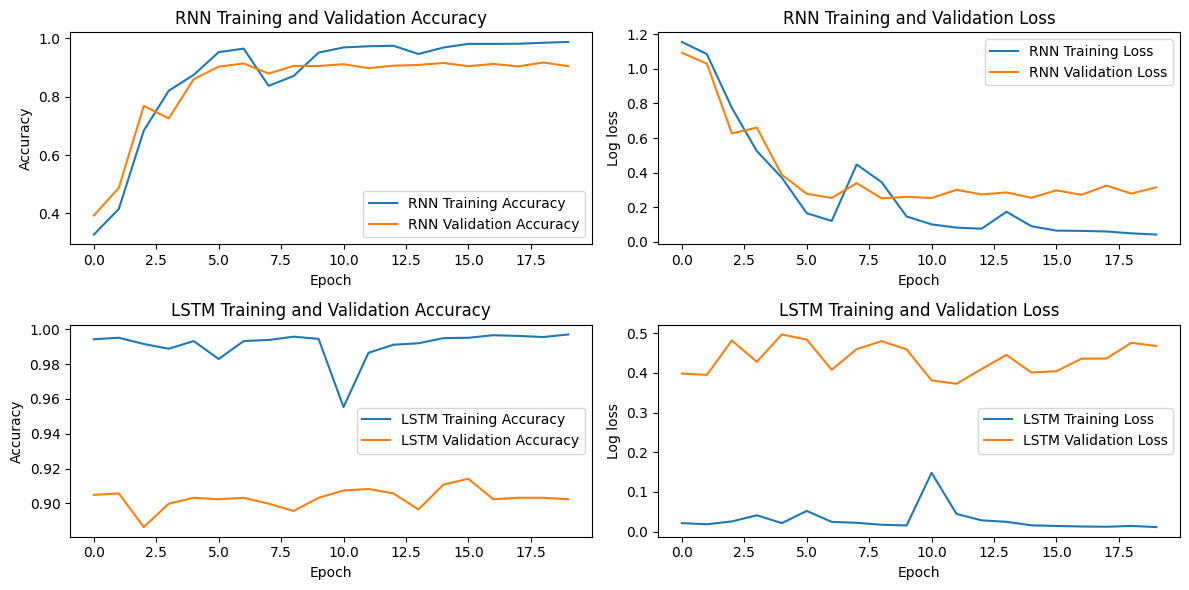

In [131]:
plt.figure(figsize=(12, 6))

# Plot RNN Training and Validation Accuracy/Loss
plt.subplot(2, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.title('RNN Training and Validation Loss')
plt.legend()

# Plot LSTM Training and Validation Accuracy/Loss
plt.subplot(2, 2, 3)
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [137]:
# Classification report
y_pred = np.argmax(lstm_model.predict(padded_validation), axis=-1)
print("Classification Report:")
print(classification_report(validation_label_seq, y_pred, zero_division=1))

38/38 [==============================] - 6s 171ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00       390
           2       1.00      0.00      0.00       396
           3       0.34      1.00      0.51       402

    accuracy                           0.34      1188
   macro avg       0.78      0.33      0.17      1188
weighted avg       0.78      0.34      0.17      1188



In [138]:
# Classification report
y_pred = np.argmax(rnn_model.predict(padded_validation), axis=-1)
print("Classification Report:")
print(classification_report(validation_label_seq, y_pred, zero_division=1))

38/38 [==============================] - 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.88      0.90       390
           2       0.88      0.92      0.90       396
           3       0.91      0.91      0.91       402

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



## Model testing

In [142]:
# Gunakan model untuk membuat prediksi
def predict_emotion(model, tokenizer, text):
    # Tokenisasi teks
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    # Lakukan prediksi
    prediction = model.predict(padded)
    # Ambil label emosi yang paling mungkin
    label = np.argmax(prediction)
    # Konversi label kembali ke label teks
    label_map = {v: k for k, v in label_tokenizer.word_index.items()}
    emotion = label_map[label]
    return emotion

sentences = [
    "Winning the customer service award filled me with joy and pride, knowing that my hard work and dedication were recognized.",
    "The repeated delays and poor customer service from this company have left me feeling angry and frustrated, leading me to consider taking my business elsewhere."
]

# Prediksi emosi untuk setiap kalimat
for sentence in sentences:
    emotion = predict_emotion(rnn_model, tokenizer, sentence)
    print(f"Kalimat: {sentence}")
    print(f"Emosi: {emotion}")
    print()

1/1 [==============================] - 0s 28ms/step
Kalimat: Winning the customer service award filled me with joy and pride, knowing that my hard work and dedication were recognized.
Emosi: joy

1/1 [==============================] - 0s 27ms/step
Kalimat: The repeated delays and poor customer service from this company have left me feeling angry and frustrated, leading me to consider taking my business elsewhere.
Emosi: anger



--- End of Code ---